### 顕著性マップ

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# BGR -> GRAY
def BGR2GRAY(img):
    gray = 0.2126 * img[..., 2] + 0.7152 * img[..., 1] + 0.0722 * img[..., 0]
    return gray

# Bi-Linear interpolation
def bl_interpolation(img, ax=1., ay=1.):
    if len(img.shape) >2:
        H, W, C = img.shape
        
    else:
        H, W = img.shape
        C = 1
        
    aH = int(ay*H)
    aW = int(ax*W)
    
    # get position of resize image
    y = np.arange(aH).repeat(aW).reshape(aW, -1)
    x = np.tile(np.arange(aW), (aH, 1))
    
    # get position of  original position
    y = (y/ay)
    x = (x/ax)
    
    ix = np.floor(x).astype(np.int)  # 切り捨て
    iy = np.floor(y).astype(np.int)
    
    ix = np.minimum(ix, W-2)  # W-2を超えないように調節　なぜ？
    iy = np.minimum(iy, H-2)
    
    # get distence
    dx = x - ix
    dy = y - iy
    
    # ３次元画像の場合は3次元に修正
    if C>1:
        dx =  np.repeat(np.expand_dims(dx, axis=-1), C, axis=-1)
        dy =  np.repeat(np.expand_dims(dy, axis=-1), C, axis=-1)
    
    # interpolation
    out = (1-dx) * (1-dy) * img[iy, ix] + (dx)*(1-dy)*img[iy, ix+1] + (1-dx)*dy*img[iy+1, ix] + dy*dx*img[iy+1, ix+1]
    
    out = np.clip(out, 0, 255)
    out = out.astype(np.uint8)
    
    return out


def make_pyramid(gray):
    # first element
    pyramid = [gray]
    
    # each scale
    for i in range(1,6):
        # define scale
        a = 2.**i
        
        # down scale
        p =bl_interpolation(gray, ax=1./a, ay=1./a)
        
        # up scale
        p = bl_interpolation(p, ax=a, ay=a)
        
        # add pylamid list
        pyramid.append(p.astype(np.float32))
        
    return pyramid

def saliency(pyramid):
    H, W = pyramid[0].shape
    
    out = np.zeros((H,W), dtype=np.float32)
    
    out += np.abs(pyramid[0] - pyramid[1])
    out += np.abs(pyramid[0] - pyramid[2])
    out += np.abs(pyramid[0] - pyramid[3])
    out += np.abs(pyramid[0] - pyramid[4])
    out += np.abs(pyramid[0] - pyramid[5])
    out += np.abs(pyramid[1] - pyramid[2])
    out += np.abs(pyramid[1] - pyramid[3])
    out += np.abs(pyramid[1] - pyramid[4])
    out += np.abs(pyramid[1] - pyramid[5])
    out += np.abs(pyramid[2] - pyramid[3])
    out += np.abs(pyramid[2] - pyramid[4])
    out += np.abs(pyramid[2] - pyramid[5])
    out += np.abs(pyramid[3] - pyramid[4])
    out += np.abs(pyramid[3] - pyramid[5])
    out += np.abs(pyramid[4] - pyramid[5])
    
    # normalization
    out = out/out.max() * 255
    
    return out

True

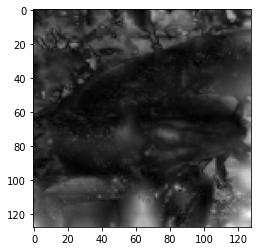

In [6]:
img = cv2.imread('../imori.jpg')
gray = BGR2GRAY(img)

pyramid = make_pyramid(gray)
out = saliency(pyramid)


plt.imshow(out, cmap='gray')

cv2.imwrite('out76.jpg', out)